In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np

In [13]:
data_dir = '/home/roy/neural/box'


train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=3, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=3,shuffle=True)

classes = ['blue', 'green', 'red']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


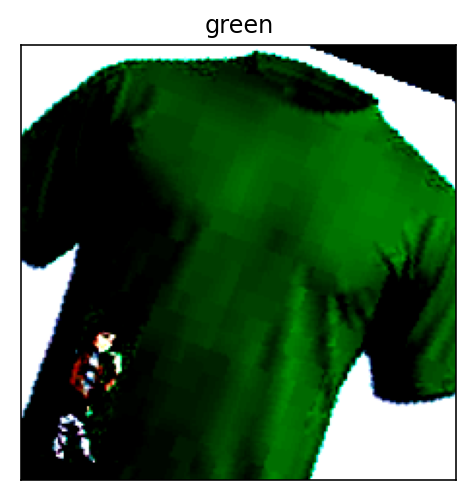

In [14]:

dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(1):
    ax = fig.add_subplot(1,1, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [4]:
model = models.resnet152(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



for param in model.parameters():
    param.requires_grad = False
    
#_inputs = model.classifier[6].in_features

#last_layer = nn.Linear(n_inputs, len(classes))
last_layer = nn.Sequential(nn.Linear(2048, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                          nn.Linear(256, 100),
                                nn.ReLU(),
                               nn.Dropout(0.2),
                                 nn.Linear(100, 3),
                                 nn.LogSoftmax(dim=1))
model.fc = last_layer

#print(model.classifier[4].out_features)
print(model)

criterion = nn.NLLLoss()


optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

model.to(device);

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
import time
epochs = 20
steps = 0
running_loss = 0
train_losses, test_losses,accuracy_acc = [], [],[]
start = time.time()
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                logps = model(inputs)
                batch_loss = criterion(logps, labels)
                    
                test_loss += batch_loss.item()
                    
               
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        accuracy_acc.append(accuracy/len(testloader))
                    
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
          "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
          "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        running_loss = 0
        model.train()
print("Time required: "+str(time.time() - start)+" seconds")

Epoch: 1/20..  Training Loss: 1.335..  Test Loss: 1.280..  Test Accuracy: 0.318
Epoch: 2/20..  Training Loss: 1.124..  Test Loss: 0.872..  Test Accuracy: 0.917
Epoch: 3/20..  Training Loss: 1.063..  Test Loss: 0.909..  Test Accuracy: 0.538
Epoch: 4/20..  Training Loss: 1.011..  Test Loss: 0.824..  Test Accuracy: 0.371
Epoch: 5/20..  Training Loss: 0.941..  Test Loss: 0.582..  Test Accuracy: 0.788
Epoch: 6/20..  Training Loss: 0.916..  Test Loss: 0.302..  Test Accuracy: 0.985
Epoch: 7/20..  Training Loss: 0.768..  Test Loss: 0.286..  Test Accuracy: 0.977
Epoch: 8/20..  Training Loss: 0.785..  Test Loss: 0.163..  Test Accuracy: 0.992
Epoch: 9/20..  Training Loss: 0.610..  Test Loss: 0.133..  Test Accuracy: 0.977
Epoch: 10/20..  Training Loss: 0.716..  Test Loss: 0.191..  Test Accuracy: 0.992
Epoch: 11/20..  Training Loss: 1.078..  Test Loss: 0.582..  Test Accuracy: 0.833
Epoch: 12/20..  Training Loss: 0.855..  Test Loss: 0.419..  Test Accuracy: 0.992
Epoch: 13/20..  Training Loss: 0.583.

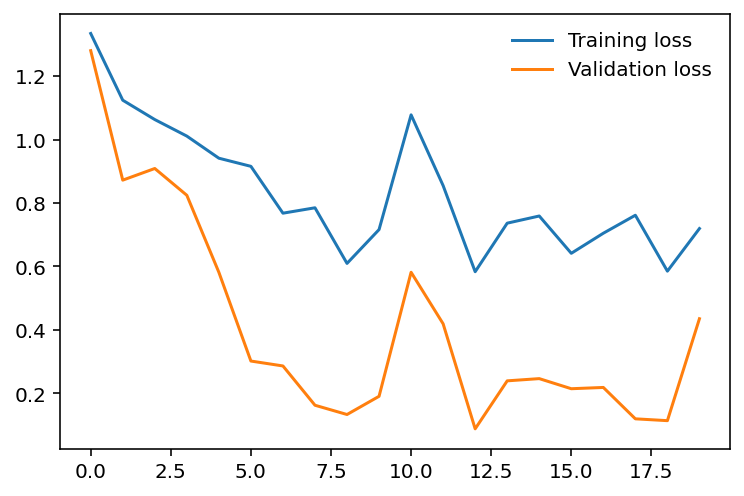

In [18]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

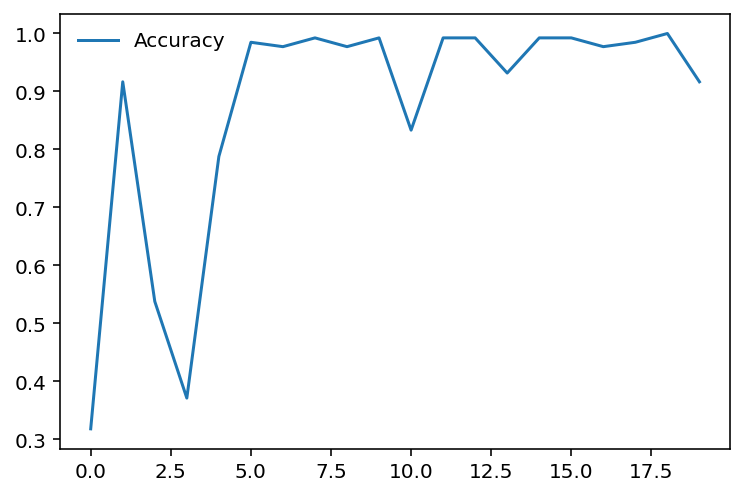

In [19]:
plt.plot(accuracy_acc, label='Accuracy')
plt.legend(frameon=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[-1.2729, -1.0233, -1.0200]], grad_fn=<LogSoftmaxBackward>)
tensor([2])
2
Prediciton red
True class green


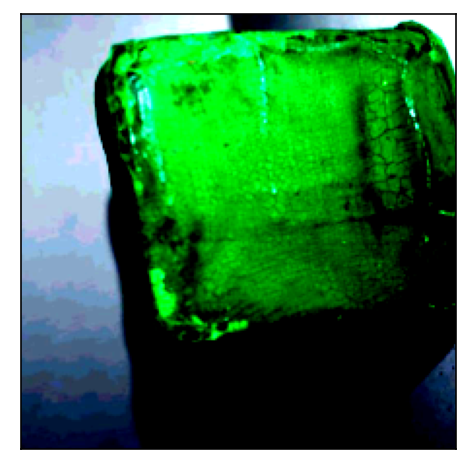

In [29]:

testloader = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=True)

dataiter = iter(testloader)
images, labels = dataiter.next()
images.numpy()
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    images = images.cuda()


output = model(images)
print(output)
_, preds_tensor = torch.max(output, 1)
print(preds_tensor)

preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

print(preds)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(1):
    ax = fig.add_subplot(1, 1, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    print("Prediciton "+classes[preds])
    print("True class "+classes[labels])
    